# OCR-BCTR模型应用

In [1]:
import cv2
import sophon.sail as sail
import zhconv
import numpy as np
import torch
import matplotlib.pyplot as plt

## 定义一个类，把推理得到的输出解码成文字形式

In [2]:
class strLabelConverter(object):
    def __init__(self, alphabet, ignore_case=False):  # ignore_case为是否忽略大小写
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()  # 如果忽略大小写就全部变为小写字符
        alphabet = list(alphabet)  # 将字符串转换为列表 例:'abc'→['a','b','c']
        alphabet.append('BLANK')  # 增加空白符
        self.alphabet = alphabet
        self.dict = {}
        for i, char in enumerate(alphabet):
            self.dict[char] = i + 1  # 把字符转化成索引，每一个都加1，0索引留给空白符

    def encode(self, text):
        """
        把字符映射成对应索引编号，所有字符编号从1开始数的
        text可以是str或者list of str
        """
        if isinstance(text, str):  # 传入单个字符串
            text_raw = text
            text = []
            for char in text_raw:
                if char not in self.dict.keys():
                    text.append(0)
                else:
                    text.append(self.dict[char])

            length = len(text)
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, texts, lengths, raw=False):
        """
        把ctc生成的路径映射成最终的序列
        """
        if lengths.numel() == 1:
            length = lengths[0]
            #  带有空白符的原始预测结果
            if raw:  # 预测的索引编号减1找到字母表中的字符，其中算法预测出0为空白符，减1后为-1恰好为最后一个字符
                return ''.join([self.alphabet[i - 1] for i in texts])
            else:
                text = []
                for i in range(length):
                    # 遇到非编号为0的空白符和非两个相邻的字符相同时，才保存下来
                    if (texts[i] != 0) and (not (i > 0 and texts[i] == texts[i - 1])):
                        text.append(self.alphabet[texts[i] - 1])
                return ''.join(text)
        else:
            res = []
            index = 0
            for i in range(lengths.numel()):
                res.append(self.decode(texts[index: index + lengths[i]], torch.IntTensor([lengths[i]]), raw=raw))
                index += lengths[i]
            return res

## 从所填路径中读取一张图片，并将其可视化

(32, 256, 3)


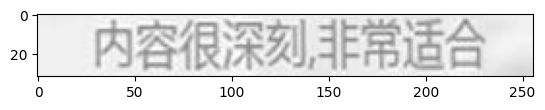

In [3]:
raw_img = cv2.imread('/home/bjut1205/LIMENGRAN/calidataset/3.jpg')
img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
print(raw_img.shape)
plt.imshow(img)
plt.show()

## 进行输入图片的预处理

In [4]:
resize_img = cv2.resize(raw_img,(256,32))
img0 = np.swapaxes(resize_img, 0, 2)
img = np.swapaxes(img0, 1, 2)
img = np.expand_dims(img, 0)  # (1,3,32,256)
img = img.astype('float32')/255.0  # 0~1
img = (img-0.5)/0.5  # -1~1
data_dict = {'input': img}

## 进行模型推理得到输出数据

In [5]:
alpha_file = open('/home/bjut1205/LIMENGRAN/benchmark.txt', 'r', encoding='utf-8')
alphabet = alpha_file.read()
converter = strLabelConverter(alphabet)
engine = sail.Engine('/home/bjut1205/LIMENGRAN/crnn_1684x_f32_1.bmodel', 0, sail.IOMode.SYSIO)
graph_name = engine.get_graph_names()[0]  # get_graph_names-test_output
outputs = engine.process(graph_name, data_dict)  # model inference

## 将输出数据解码成文字形式，并显示出来

In [9]:
outputs_key = list(outputs.keys())[0]
preds = torch.tensor(outputs[outputs_key])
preds_size = torch.IntTensor([preds.size(0)])
_, preds = preds.max(2)  # 取可能性最大的字符类别 (t,b,nclass)
preds = preds.transpose(1, 0).contiguous().view(-1)
res_real = converter.decode(preds, preds_size, raw=False)
print(res_real)

内容很深刻,非常适合
